Kyle Zhang 1662956


Justin Culpepper 1242439

# References

        [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
            Gramfort, A. (2018). A deep learning architecture for temporal sleep
            stage classification using multivariate and multimodal time series.
            IEEE Transactions on Neural Systems and Rehabilitation Engineering,
            26(4), 758-769.
        [2] Banville, H (2020) dl-eeg-tutorial
            (Version 1.0) [Source code].https://github.com/hubertjb/
            dl-eeg-tutorial/blob/main/sleep_staging_physionet.ipynb
        [3] Stober, S (2014) deepthought
            (Version 1.0) [Source code].
            https://github.com/sstober/deepthought

# Data/Preprocessing

### Libraries/Tools

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!pip3 install torch torchvision torchaudio
!pip install mne

In [ ]:
import logging
log = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
from torch import nn
import numpy as np
import pandas as pd
import os
import copy
import xlrd

import mne
from mne.channels import rename_channels
from mne.viz.topomap import plot_topomap
from mne.preprocessing import ICA, read_ica
from mne.io import read_raw

In [ ]:
root = "/content/gdrive/Shareddrives/CSEN 239A: Brain Computer Interface"
fname = "/content/gdrive/Shareddrives/CSEN 239A: Brain Computer Interface/P01-raw.fif"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Import/Load Raw

In [ ]:
def print_raw_info(raw):
    print(raw.info)
    raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
    raw.plot(duration=5, n_channels=30)

In [ ]:
def print_bad_channels(raw):
    print(raw.info['bads'])
    raw.interpolate_bads()
#epoch.interpolate_bads() # for epoched data

### Check and Merge Trials

In [ ]:
def check_trial_events(raw, verbose=False):
    trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)
    print(trial_events)

    plt.figure(figsize=(17,10))
    axes = plt.gca()
    mne.viz.plot_events(trial_events, raw.info['sfreq'], raw.first_samp, axes=axes)
    print(raw.times[trial_events[0,0]])
    print(raw.times[trial_events[-1,0]])
    trial_event_times = raw.times[trial_events[:,0]]

    return trial_events, trial_event_times

In [ ]:
def merge(raw, use_audio_onsets=True, inplace=True, stim_channel='STI 014', verbose=None):
    events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)

    merged = list()
    last_trial_event = None
    for i, event in enumerate(events):
        etype = event[2]
        if etype < 1000 or etype == 1111: # trial or noise onset
            if use_audio_onsets and events[i+1][2] == 1000: # followed by audio onset
                onset = events[i+1][0]
                merged.append([onset, 0, etype])
                if verbose:
                    log.debug('merged {} + {} = {}'.format(event, events[i+1], merged[-1]))
            else:
                # either we are not interested in audio onsets or there is none
                merged.append(event)
                if verbose:
                    log.debug('kept {}'.format(merged[-1]))
        # audio onsets (etype == 1000) are not copied
        if etype > 1111: # other events (keystrokes)
            merged.append(event)
            if verbose:
                log.debug('kept other {}'.format(merged[-1]))

    merged = np.asarray(merged, dtype=int)

    if inplace:
        stim_id = raw.ch_names.index(stim_channel)
        raw._data[stim_id,:].fill(0)     # delete data in stim channel
        raw.add_events(merged)

    return merged

In [ ]:
def check_trial_audio_onset_merge(raw, use_audio_onsets=True, verbose=None):
    ## check whether trial and audio events are merged correctly
    merged_events = merge(raw, use_audio_onsets=use_audio_onsets, inplace=False)
    if verbose:
        for event in merged_events:
            print(event)

    plt.figure(figsize=(17,10))
    axes = plt.gca()
    mne.viz.plot_events(merged_events, raw.info['sfreq'], raw.first_samp, axes=axes)

In [ ]:
def merge_trial_and_audio_onsets(raw, trial_events, use_audio_onsets=True):
    orig_trial_events = trial_events

    merge(raw, use_audio_onsets=use_audio_onsets, inplace=True)

    # recompute trial_events and times
    trial_events = mne.find_events(raw, stim_channel='STI 014', shortest_event=0)
    trial_event_times = raw.times[trial_events[:,0]]

    return orig_trial_events, trial_events, trial_event_times

### Check PSD

In [ ]:
def check_psd(raw, eeg_picks, fmax=None):
    plt.figure(figsize=(17,5))
    axes = plt.gca()
    raw.plot_psd(area_mode='range', tmax=10.0, ax=axes, picks=eeg_picks, fmax=fmax)

In [ ]:
def check_channel(raw, ch_num):
    channel = raw[ch_num,:][0].squeeze()
    print(channel.shape)
    plt.figure(figsize=(17,4))
    plt.plot(channel)

### BandPass Filtering

In [ ]:
def bandpass_filter(raw, eeg_picks):
    raw.filter(0.5, 30, picks=eeg_picks, filter_length='40s',
                l_trans_bandwidth=0.1, h_trans_bandwidth=0.5, method='fft',
                n_jobs=4, verbose=True)
    return True

### EOG Epoching

In [ ]:
# ## compute EOG epochs before downsampling
def find_eog_events(raw, filtered=True, downsampled=False, verbose=None):

    assert filtered is True
    assert downsampled is False

    # check for EOG artifacts:
    # NOTE: this should NOT be done after resampling!
    eog_event_id = 5000
    eog_events = mne.preprocessing.find_eog_events(raw, eog_event_id)

    plt.figure(figsize=(17,0.5))
    axes = plt.gca()
    mne.viz.plot_events(eog_events, raw.info['sfreq'], raw.first_samp, axes=axes)

    # create epochs around EOG events
    picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True, stim=True, exclude=[]) # FIXME
    tmin = -.5
    tmax = .5
    eog_epochs = mne.Epochs(raw, events=eog_events, event_id=eog_event_id,
                        tmin=tmin, tmax=tmax, proj=False, picks=picks,
                        preload=True, verbose=False)

    return eog_events, eog_epochs

###Event Meta Data & Epoching

In [ ]:
def get_stimuli_version(subject):
    if subject in ['Pilot3','P01','P04','P05','P06','P07']:
        return 1
    else:
        return 2

In [ ]:
def decode_trial_event_type(etype):
    stimulus_id = int(etype / 10)
    condition = etype % 10
    return stimulus_id, condition

In [ ]:
def filter_trial_events(events, stimulus_ids='any', conditions='any'):
#     print 'selected stimulus ids:', stimulus_ids
#     print 'selected conditions  :', conditions
    filtered = list()

    for event in events:
        etype = event[2]
        if etype >= 1000:
            continue

        stimulus_id, condition = decode_trial_event_type(etype)
        if (stimulus_ids == 'any' or stimulus_id in stimulus_ids) and \
                (conditions == 'any' or condition in conditions):
            filtered.append(event)
    return np.asarray(filtered)

In [ ]:
def load_stimuli_metadata(data_root=None, version=None, verbose=None):

    if version is None:
        version = 1

    if data_root is None:
        data_root = "/content/gdrive/Shareddrives/CSEN 239A: Brain Computer Interface"

    xlsx_filepath = os.path.join(data_root, 'Stimuli_Meta.v{}.xls'.format(version))
    book = xlrd.open_workbook(xlsx_filepath, encoding_override="cp1252")
    sheet = book.sheet_by_index(0)

    if verbose:
        log.info('Loading stimulus metadata from {}'.format(xlsx_filepath))

    meta = dict()
    for i in range(1, 13):
        stimulus_id = int(sheet.cell(i,0).value)
        meta[stimulus_id] = {
            'id' : stimulus_id,
            'label' : sheet.cell(i,1).value.encode('ascii'),
            'audio_file' : sheet.cell(i,2).value.encode('ascii'),
            'cue_file' : sheet.cell(i,2).value.encode('ascii'), #.replace('.wav', '_cue.wav'),
            'length_with_cue' : sheet.cell(i,3).value,
            'length_of_cue' : sheet.cell(i,4).value,
            'length_without_cue' : sheet.cell(i,5).value,
            'length_of_cue_only' : sheet.cell(i,6).value,
            'cue_bpm' : int(sheet.cell(i,7).value),
            'beats_per_bar' : int(sheet.cell(i,8).value),
            'num_bars' : int(sheet.cell(i,14).value),
            'cue_bars' : int(sheet.cell(i,15).value),
            'bpm' : int(sheet.cell(i,16).value),
            'approx_bar_length' : sheet.cell(i,11).value,
        }

        if version == 2:
            meta[stimulus_id]['bpm'] = meta[stimulus_id]['cue_bpm'] # use cue bpm

    return meta

In [ ]:
def get_trial_epochs(raw, trial_events, stim_id, condition,
                     subject=None, stimuli_version=None, meta=None,
                     include_cue=False, picks=None, debug=False):

    assert subject is None or stimuli_version is None or meta is None

    if meta is None:
        if stimuli_version is None:
            if subject is None:
                raise RuntimeError('Either meta, stimuli_version or subject has to be specified.')
            else:
                stimuli_version = get_stimuli_version(subject)
        meta = load_stimuli_metadata(version=stimuli_version)
    events = filter_trial_events(trial_events, [stim_id], [condition])
    print(events)
    if debug:
        log.debug('selected events: {}'.format(len(events)))
        log.debug(events)

    start = 0
    if condition in [1,2]: # cued
        if include_cue:
            stop = meta[stim_id]['length_with_cue']
        else:
            # NOTE: start > 0 does not work; need to shift event time
            offset = int(np.floor(meta[stim_id]['length_of_cue'] * raw.info['sfreq']))
            events[:,0] += offset
            stop = meta[stim_id]['length_without_cue']
    else:
        stop = meta[stim_id]['length_without_cue']
    stop = 20
    if debug:
        log.debug('start: {}  stop: {}'.format(start, stop))
        log.debug(events)

    if picks is None:
        # default: all EEG channels including bad/interpolated

        picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])


    epochs = mne.Epochs(raw, events, None,
                              tmin=start, tmax=stop, preload=True,baseline=None,
                              proj=False, picks=picks, verbose=False)
    if debug:
        log.debug(epochs)

    return epochs

### Preprocessing

Opening raw data file /content/gdrive/Shareddrives/CSEN 239A: Brain Computer Interface/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
<Info | 11 non-empty values
 bads: 3 items (P8, P10, T8)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2015-01-28 17:39:57 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: Average EEG reference: off
 sfreq: 512.0 Hz
>
Effective window size : 4.000 (s)


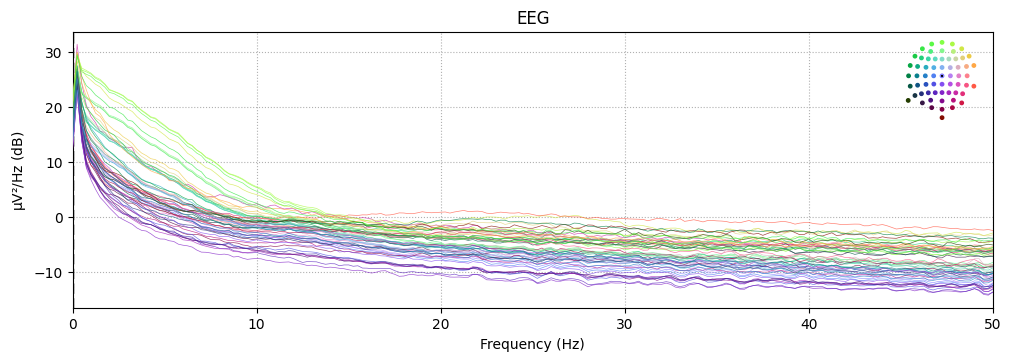

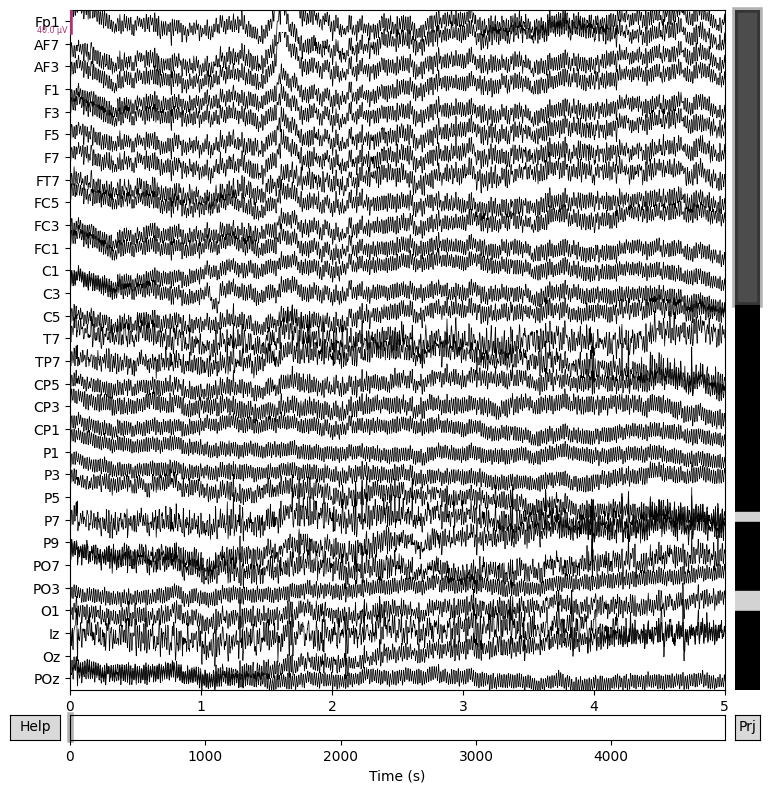

540 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
[[    512       0     121]
 [    520       0    1000]
 [   8141       0     122]
 ...
 [2459915       0    2001]
 [2467882       0     224]
 [2467925       0    2001]]


<ipython-input-51-7d51c2e4ecfc>:7: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(trial_events, raw.info['sfreq'], raw.first_samp, axes=axes)


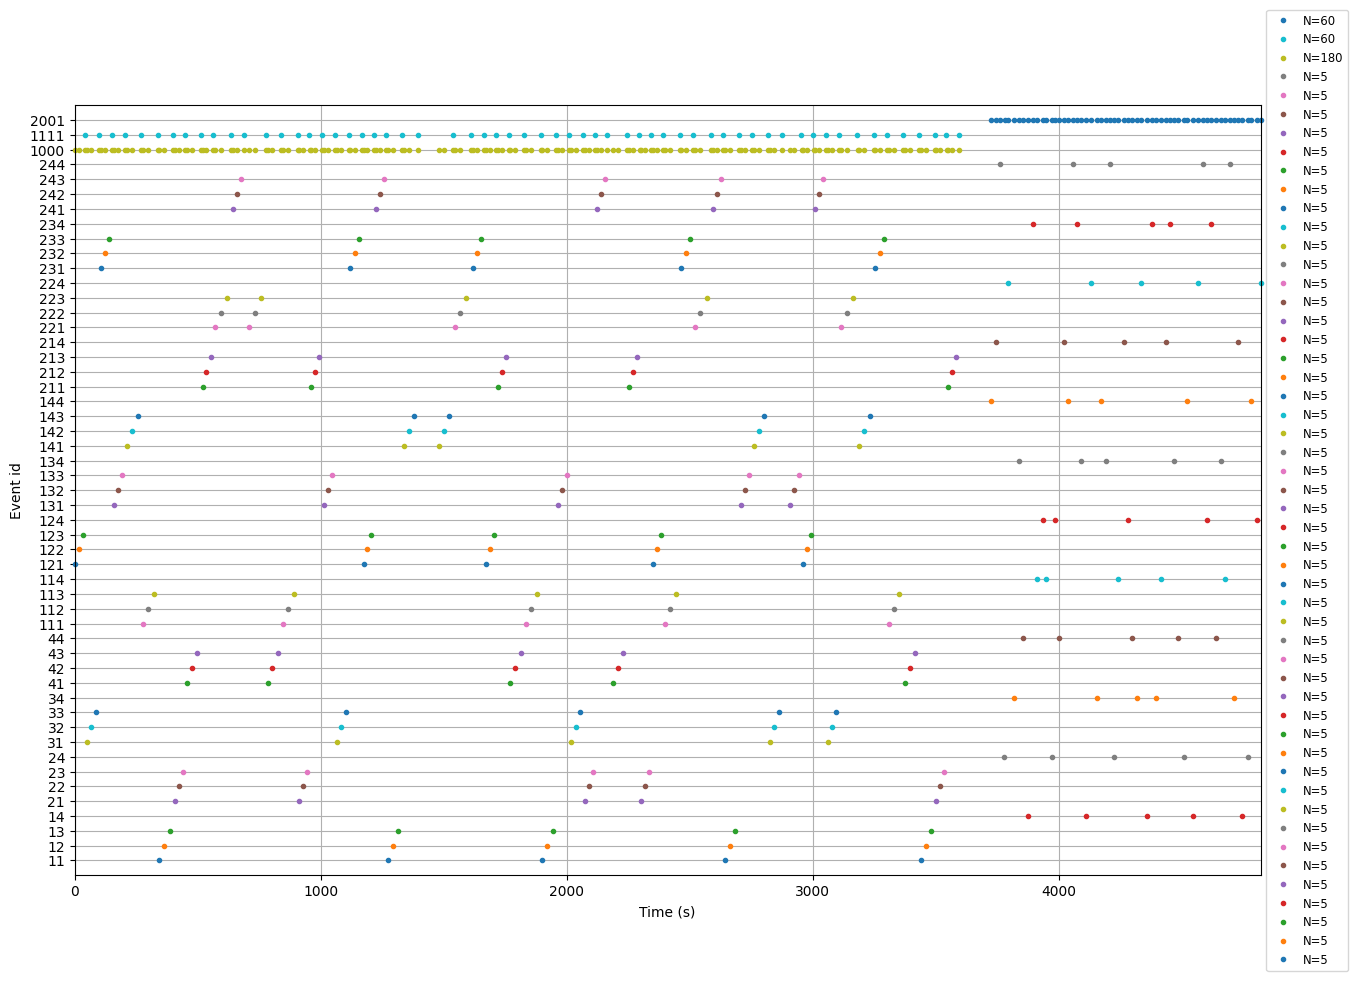

1.0
4820.166015625
540 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]


<ipython-input-53-c426a59aa6a1>:10: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(merged_events, raw.info['sfreq'], raw.first_samp, axes=axes)


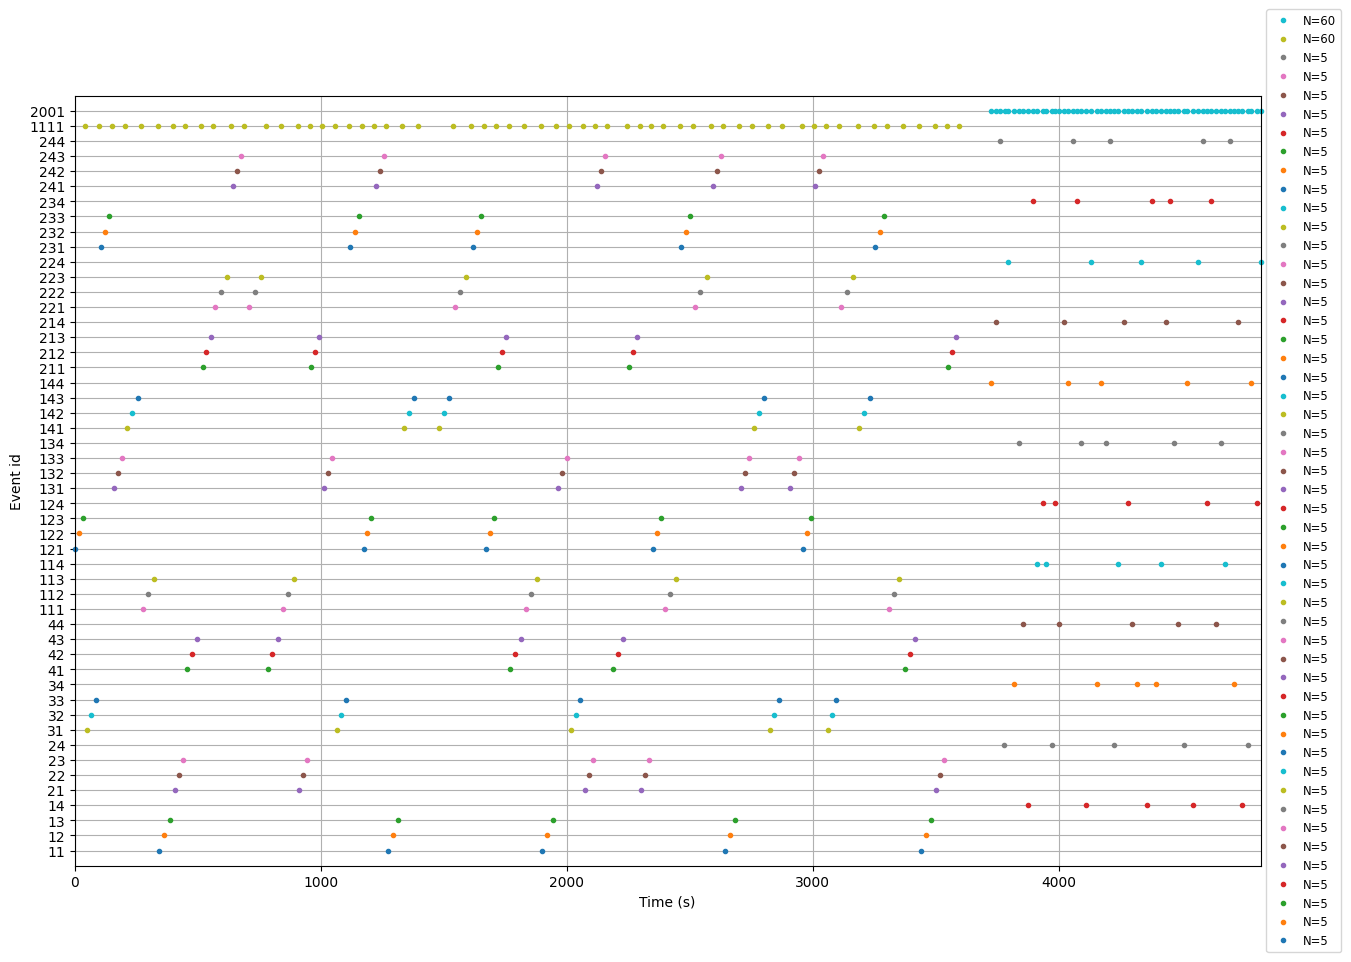

540 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
360 events found on stim channel STI 014
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1111 2001]
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
(2478166,)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming win

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:   18.7s finished


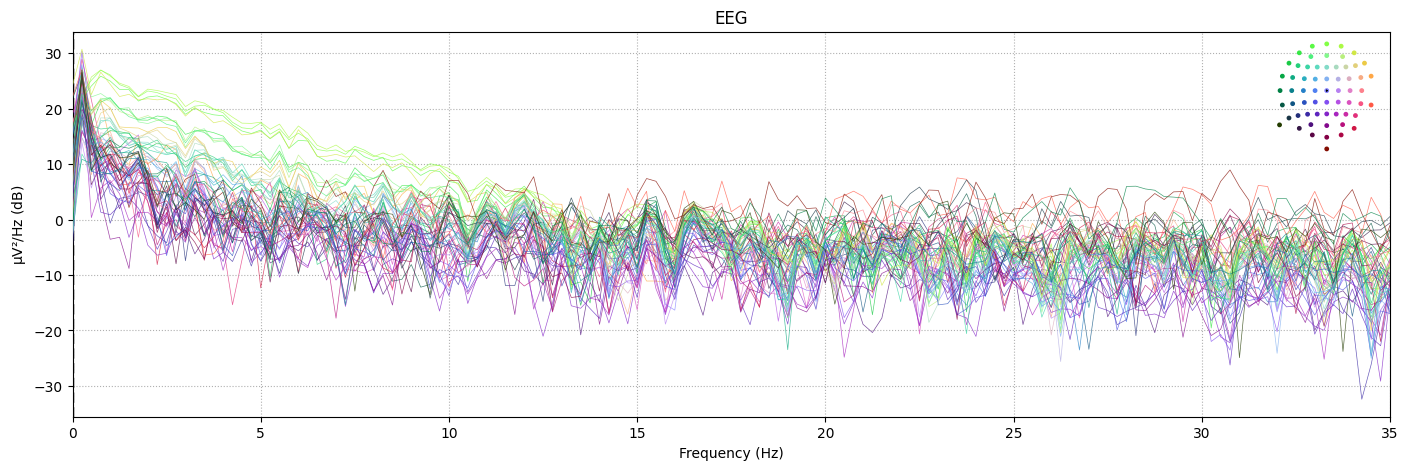

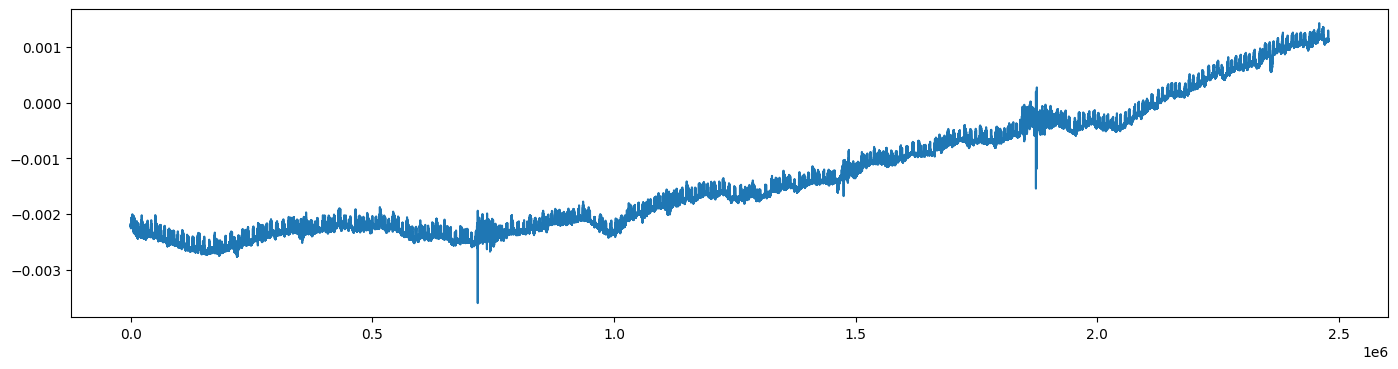

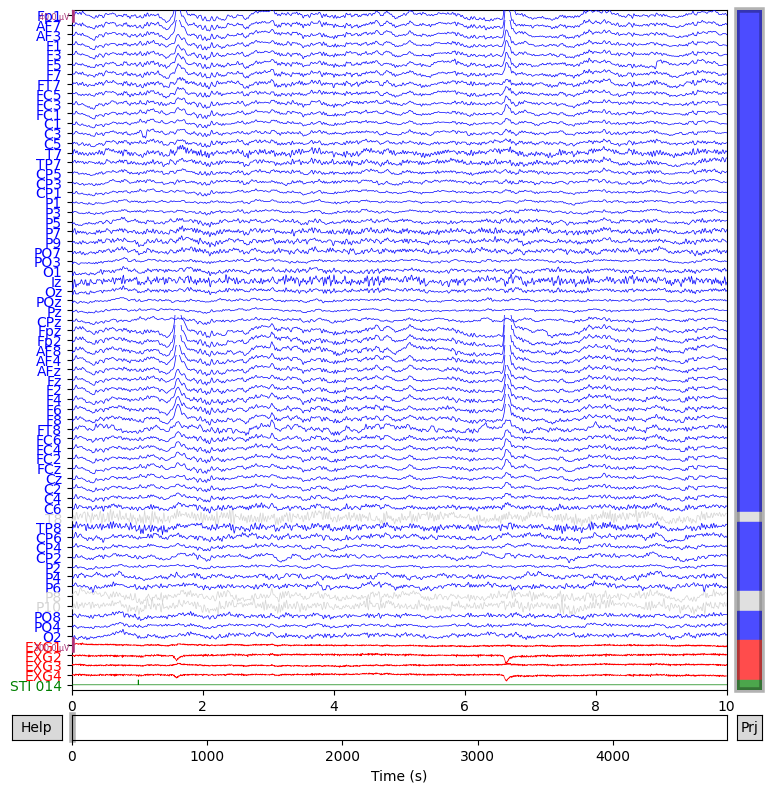

(2478166,)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Using EOG channels: EXG1, EXG2, EXG3, EXG4
EOG channel index for this subject is: [64 65 66 67]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 1579 significant peaks
Number of EOG events detected: 1579


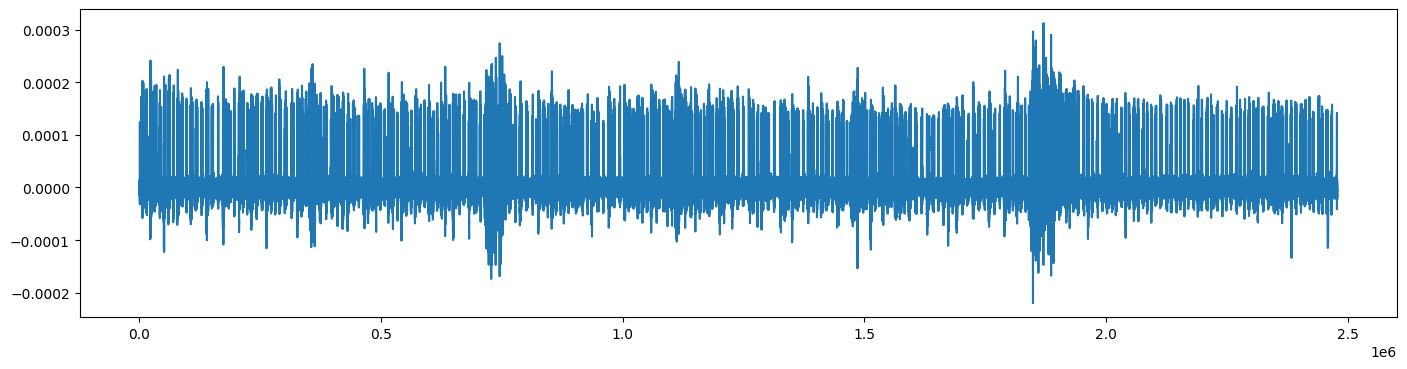

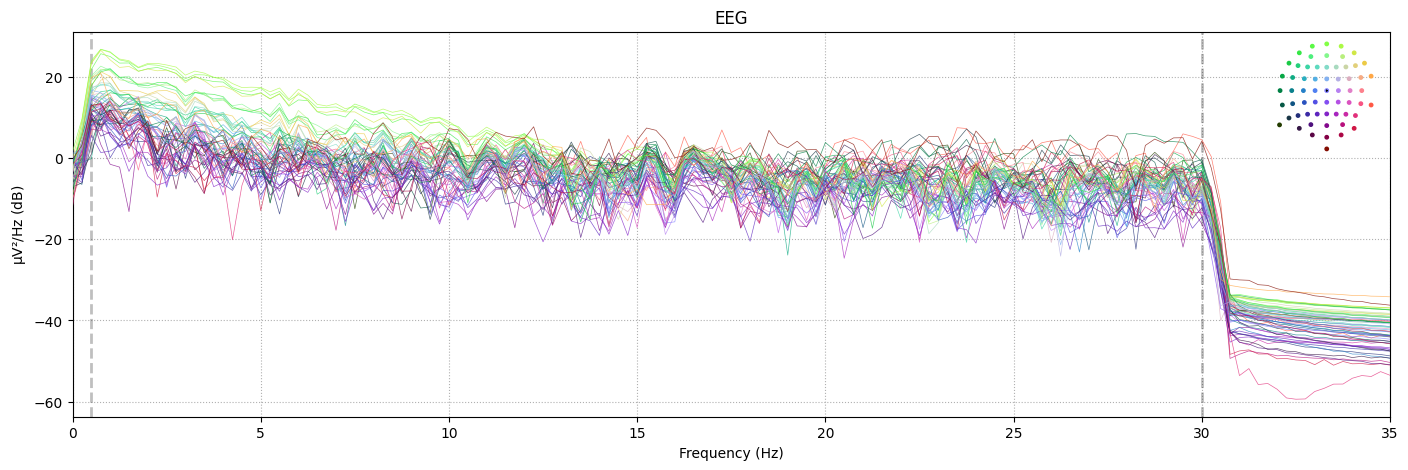

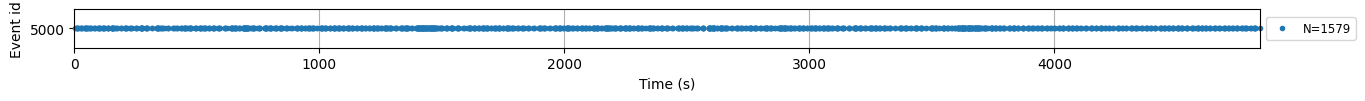

Using EOG channels: EXG1, EXG2, EXG3, EXG4
EOG channel index for this subject is: [64 65 66 67]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 1579 significant peaks
Number of EOG events detected: 1579
Not setting metadata
1579 matching events found
No baseline correction applied
Using data from preloaded Raw for 1579 events and 513 original time points ...
0 bad epochs dro

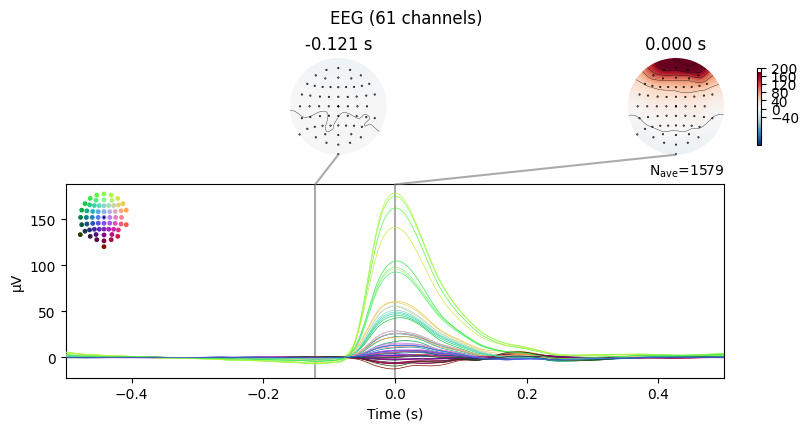

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 110.6s.
Creating RawArray with float64 data, n_channels=24, n_times=2478166
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.


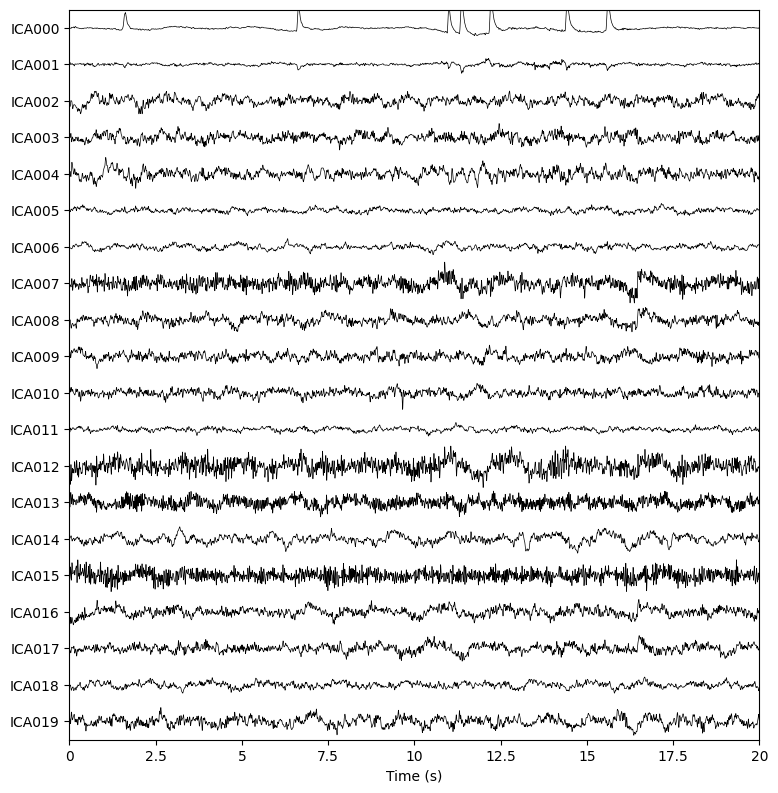

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
2420 matching events found
No baseline correction applied
0 projection items activated


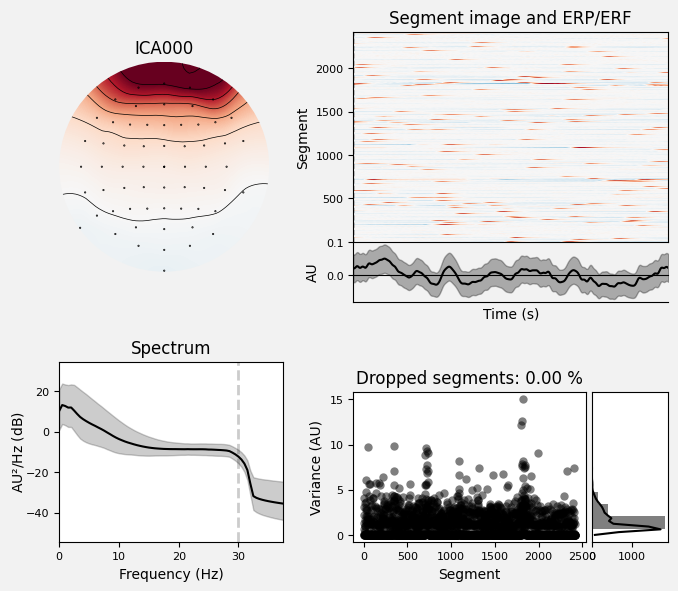

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components


In [ ]:
raw_dir = '/content/gdrive/Shareddrives/CSEN 239A: Brain Computer Interface'
patients = ['P01', 'P04', 'P05', 'P06', 'P07', 'P09', 'P11', 'P12', 'P13', 'P14']
#patients = ['P01']
raws = []
for patient_id in patients:
    fname = os.path.join(raw_dir, '{}-raw.fif'.format(patient_id))
    raw = read_raw(fname, preload=True)
    eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
    print_raw_info(raw)
    #print_bad_channels(raw)

    trial_events, trial_event_times = check_trial_events(raw)
    check_trial_audio_onset_merge(raw, use_audio_onsets=True, verbose=None)
    orig_trial_events, trial_events, trial_event_times = merge_trial_and_audio_onsets(raw, trial_events, use_audio_onsets=True)

    check_psd(raw, eeg_picks, fmax=35)

    check_channel(raw, 0)

    bandpass_filter(raw, eeg_picks)

    color = dict(eeg='blue',eog='red', stim='green')
    raw.plot(n_channels=69, remove_dc=True, color=color)

    check_channel(raw, 0)
    check_psd(raw, eeg_picks, fmax=35)

    eog_events, eog_epochs = find_eog_events(raw, filtered=True, downsampled=False, verbose=None)

    eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()
    eog_evoked.apply_baseline(baseline=(None, -0.2))
    eog_evoked.plot_joint()

    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
    ica.fit(raw)

    raw.load_data()
    ica.plot_sources(raw, show_scrollbars=False)

    ica.exclude = [0]  # details on how we picked these are omitted here
    ica.plot_properties(raw, picks=ica.exclude)

    orig_raw = raw.copy()
    raw.load_data()
    ica.apply(raw)
    #raw.resample(64) # do resampling after eog epoching not before!
    #print(raw.info)
    raws.append(raw)

In [ ]:
stimuli_version = get_stimuli_version(patients)
meta = load_stimuli_metadata(version=stimuli_version)
trialdata = []
conditions = [1,2,3]
for raw in raws:
  for stim_id in meta:
    for condition in conditions:
      trialdata.append(get_trial_epochs(raw, trial_events, stim_id=stim_id, condition=condition, meta=meta, include_cue=False))

[[ 176289       0      11]
 [ 652049       0      11]
 [ 973216       0      11]
 [1353615       0      11]
 [1760519       0      11]]
[[ 186564       0      12]
 [ 662318       0      12]
 [ 983483       0      12]
 [1363882       0      12]
 [1770785       0      12]]
[[ 197572       0      13]
 [ 673324       0      13]
 [ 994489       0      13]
 [1374889       0      13]
 [1781791       0      13]]
[[ 209144       0      21]
 [ 467685       0      21]
 [1061777       0      21]
 [1179094       0      21]
 [1793361       0      21]]
[[ 216763       0      22]
 [ 475307       0      22]
 [1069399       0      22]
 [1186716       0      22]
 [1801035       0      22]]
[[ 224988       0      23]
 [ 483533       0      23]
 [1077625       0      23]
 [1194941       0      23]
 [1809258       0      23]]
[[  25451       0      31]
 [ 545287       0      31]
 [1033314       0      31]
 [1447135       0      31]
 [1566847       0      31]]
[[  34394       0      32]
 [ 554230       0    

###Testing Training Split


In [ ]:
from torch.utils.data import Dataset, ConcatDataset


class CreateEpochedDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.

    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None,
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y


def scale(X):
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [ ]:
def remapevents(event):
  results = []
  c = 0
  for i in range(int(len(event)/5)):
    for j in range(5):
      results.append(c)
    c +=1
  return results

In [ ]:
from torch.utils.data import random_split
totalEpochs = mne.concatenate_epochs(trialdata)
all_datasets = [CreateEpochedDataset(totalEpochs.get_data(),remapevents(totalEpochs.events[:,2]), transform=scale)
                for raw in raws]
dataset = ConcatDataset(all_datasets)
generator = torch.Generator().manual_seed(42)
train_ds, test_ds, valid_ds = random_split(dataset,[.7,.15,.15],generator)

Not setting metadata
180 matching events found
No baseline correction applied


<ipython-input-68-67952fe425b0>:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  all_datasets = [CreateEpochedDataset(totalEpochs.get_data(),remapevents(totalEpochs.events[:,2]), transform=scale)


In [ ]:
from torch.utils.data import DataLoader
# Create dataloaders

loader_train = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=0)
loader_valid = DataLoader(
    valid_ds, batch_size=128, shuffle=False, num_workers=0)
loader_test = DataLoader(
    test_ds, batch_size=128, shuffle=False, num_workers=0)

# Deep Neural Networks

### Stacked RNN Network Module

In [ ]:
class OurCoolRNN(nn.Module):
    def __init__(self, n_channels, sfreq, num_classes=32, input_size_s=20, num_layers=2,
                 dropout=0.25):
        super(OurCoolRNN, self).__init__()
        input_size = int(input_size_s * sfreq)
        self.n_channels = n_channels
        self.input_size = input_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, n_channels, num_layers)

        # Final layer to grab last hidden state outputs
        self.finallayer = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(n_channels, num_classes)
        )
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        output, hn = self.rnn(x, h0)
        output = self.finallayer(hn[-1])
        return output

### LSTM Network Module

In [ ]:
class OurCoolLSTM(nn.Module):
    def __init__(self, n_channels, sfreq, num_classes=32, input_size_s=20,
                 dropout=0.25):
        super(OurCoolLSTM, self).__init__()
        input_size = int(input_size_s * sfreq)
        self.n_channels = n_channels

        self.LSTMLayers = nn.Sequential(
            nn.LSTM(n_channels, 1, batch_first=True),
            nn.Dropout(dropout),
            nn.Linear(n_channels,n_channels),
            nn.Dropout(dropout),
            nn.Linear(n_channels // 2,n_channels//2),
            nn.Dropout(dropout)
        )
        self.finallayer = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(n_channels//2, num_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, num_classes):
        return n_channels * (input_size // (num_classes ** 2))

    def forward(self, x):
        output = self.LSTMLayers(output)
        return self.finallayer(output.flatten(start_dim=1))

### CNN Network Module

In [ ]:
class OurCoolCNN(nn.Module):
    """
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layers

    References:
        Banville, H (2020) dl-eeg-tutorial
            (Version 1.0) [Source code].https://github.com/hubertjb/
            dl-eeg-tutorial/blob/main/sleep_staging_physionet.ipynb
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=12, input_size_s=20,
                 dropout=0.25):
        super(OurCoolCNN, self).__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.finallayer = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):
        """Forward pass.

        Parameters
        ---------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.finallayer(x.flatten(start_dim=1))

### Pick Model

In [ ]:
dropout = [0.2, 0.25, 0.3, 0.4]
layers = [2, 3, 4]

# gridsearch for RNN and LSTM
for drop in dropout:
    for layer in layers:
        modelLSTM = OurCoolRNN(64, raw.info['sfreq'], num_classes=36, input_size_s=20, num_layers=layer, dropout=drop)
        modelRNN = OurCoolLSTM(64, raw.info['sfreq'], num_classes=36, input_size_s=20,dropout=drop)
modelCNN = OurCoolCNN(64, raw.info['sfreq'], n_classes=36, input_size_s=20)
model = modelCNN.to(device)

### Training

In [ ]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, f1_score, recall_score, precision_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()

    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()

        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(train_loss), perf


def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()

    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()

            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs,
          patience, device, metric=None):
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()

    if metric is None:
        metric = balanced_accuracy_score

    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch,
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})

        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [ ]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
criterion = CrossEntropyLoss()

In [ ]:
n_epochs = 12
patience = 5

best_model, history = train(
    model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience,
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 3.6495 	 3.6563 	 0.0081 	 0.0209
best val loss inf -> 3.6563
2 	 3.5531 	 3.6652 	 -0.0133 	 0.0000
3 	 3.5268 	 3.8162 	 0.0170 	 0.0000
4 	 3.4663 	 3.9878 	 0.0498 	 0.0000
5 	 3.4613 	 3.9581 	 0.0332 	 0.0000
6 	 3.4283 	 3.8274 	 0.0499 	 0.0000
Stop training at epoch 6
Best val loss : 3.6563


### Evaluation

Text(0, 0.5, "Cohen's kappa")

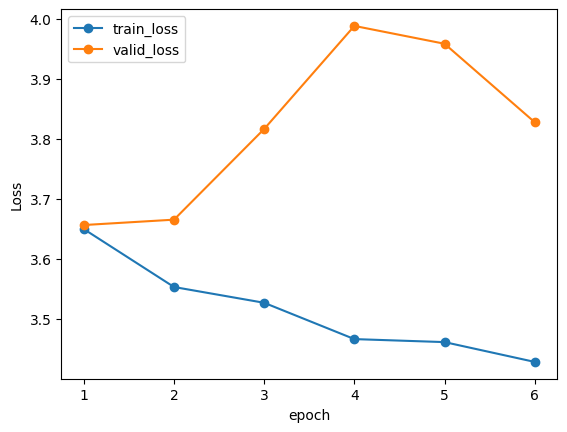

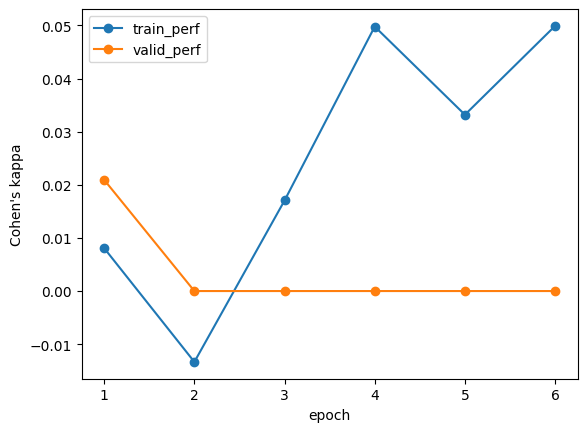

In [ ]:

history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
ax2.set_ylabel('Cohen\'s kappa')

In [ ]:
best_model.eval()

y_pred_all, y_true_all = list(), list()
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())

y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)
#test_f1 = f1_score(y_true, y_pred)
#test_recall = recall_score(y_true, y_pred)
#test_precision = precision_score(y_true, y_pred)


print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')
#print(f'Test F1 score: {test_f1:0.3f}')
#print(f'Test Recall: {test_recall:0.3f}')
#print(f'Test Precision: {test_precision:0.3f}')